In [1]:
%load_ext autoreload

In [2]:
import numpy as np
from functools import partial
from iris_plant_visualizer import IrisPlantVisualizer
import ipywidgets as widgets
from IPython.display import display
from scipy.linalg import block_diag

In [3]:
#pydrake imports
from pydrake.common import FindResourceOrThrow
from pydrake.multibody.parsing import Parser
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.systems.framework import DiagramBuilder
from pydrake.geometry import Role, GeometrySet, CollisionFilterDeclaration
from pydrake.all import RigidTransform, RollPitchYaw, RevoluteJoint
from pydrake.all import RotationMatrix, Rgba
import time
import pydrake.multibody.rational as rational_forward_kinematics
from pydrake.all import RationalForwardKinematics
from pydrake.geometry.optimization import IrisOptions, IrisInRationalConfigurationSpace, HPolyhedron, Hyperellipsoid
from pydrake.solvers import MosekSolver, CommonSolverOption, SolverOptions

In [4]:
from pydrake.geometry.optimization_dev import (CspaceFreePolytope, 
                                               SeparatingPlaneOrder)

# Build and set up the visualization the plant and the visualization of the C-space obstacle

We first set up a simple 2-DOF system and visualize both the plant and the configuration constraint.Click on the two links at the bottom to view the plant and the configuration space.

Note that running this cell multiple times will establish multiple meshcat instances which can fill up your memory. It is a good idea to call "pkill -f meshcat" from the command line before re-running this cell


In [5]:
#construct our robot
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)
parser = Parser(plant)
oneDOF_iiwa_asset = FindResourceOrThrow("drake/C_Iris_Examples/assets/oneDOF_iiwa7_with_box_collision.sdf")

box_asset = FindResourceOrThrow("drake/C_Iris_Examples/assets/box_small.urdf")

models = []
models.append(parser.AddModelFromFile(box_asset))
models.append(parser.AddModelFromFile(oneDOF_iiwa_asset, 'right_sweeper'))
models.append(parser.AddModelFromFile(oneDOF_iiwa_asset, 'left_sweeper'))
locs = [[0.,0.,0.],
        [0,1,0.85],
        [0,-1,0.55]]
plant.WeldFrames(plant.world_frame(), 
                 plant.GetFrameByName("base", models[0]),
                 RigidTransform(locs[0]))

t1 = RigidTransform(RollPitchYaw([np.pi/2, 0, 0]).ToRotationMatrix(), locs[1])@RigidTransform(RollPitchYaw([0, 0, np.pi/2]), np.zeros(3))
t2 = RigidTransform(RollPitchYaw([-np.pi/2, 0, 0]).ToRotationMatrix(), locs[2])@RigidTransform(RollPitchYaw([0, 0, np.pi/2]), np.zeros(3))
plant.WeldFrames(plant.world_frame(), 
                 plant.GetFrameByName("iiwa_oneDOF_link_0", models[1]), 
                 t1)
plant.WeldFrames(plant.world_frame(), 
                 plant.GetFrameByName("iiwa_oneDOF_link_0", models[2]), 
                 t2)


plant.Finalize()
idx = 0
q0 = [0.0, 0.0]
val = 1.7
q_low  = np.array([-val, -val])
q_high = np.array([val, val])
# set the joint limits of the plant
for model in models:
    for joint_index in plant.GetJointIndices(model):
        joint = plant.get_mutable_joint(joint_index)
        if isinstance(joint, RevoluteJoint):
            joint.set_default_angle(q0[idx])
            joint.set_position_limits(lower_limits= np.array([q_low[idx]]), upper_limits= np.array([q_high[idx]]))
            idx += 1
        
# construct the RationalForwardKinematics of this plant. This object handles the
# computations for the forward kinematics in the tangent-configuration space
Ratfk = RationalForwardKinematics(plant)

# the point about which we will take the stereographic projections
q_star = np.zeros(plant.num_positions())

do_viz = True

# The object we will use to perform our certification.
cspace_free_polytope = CspaceFreePolytope(plant, scene_graph, SeparatingPlaneOrder.kAffine, q_star)

# This line builds the visualization. Change the viz_role to Role.kIllustration if you
# want to see the plant with its illustrated geometry or to Role.kProximity if you want
# to see the plant with the collision geometries.
visualizer = IrisPlantVisualizer(plant, builder, scene_graph, cspace_free_polytope, viz_role=Role.kIllustration)
visualizer.visualize_collision_constraint(factor = 1.2, num_points = 100)
visualizer.meshcat_cspace.Set2dRenderMode(RigidTransform(RotationMatrix.MakeZRotation(0), np.array([0,0,1])))
visualizer.meshcat_task_space.Set2dRenderMode(RigidTransform(RotationMatrix.MakeZRotation(0), np.array([1,0,0])))

INFO:drake:Meshcat listening for connections at http://localhost:7000
INFO:drake:Meshcat listening for connections at http://localhost:7001


## Set up the sliders so we can move the plant around manually

You can use the sliders below to move the two degrees of freedom of the plant around. A green dot will appear in the TC-space visualization describing the current TC-space configuration.

In [6]:
sliders = []
sliders.append(widgets.FloatSlider(min=q_low[0], max=q_high[0], value=0, description='q0'))
sliders.append(widgets.FloatSlider(min=q_low[1], max=q_high[1], value=0, description='q1'))

q = q0.copy()
def handle_slider_change(change, idx):
    q[idx] = change['new']
    visualizer.show_res_q(q)
    
idx = 0
for slider in sliders:
    slider.observe(partial(handle_slider_change, idx = idx), names='value')
    idx+=1

for slider in sliders:
    display(slider)


FloatSlider(value=0.0, description='q0', max=1.7, min=-1.7)

FloatSlider(value=0.0, description='q1', max=1.7, min=-1.7)

# Generate and Certify Regions

Around some nominal seed postures, we will grow certified regions by seeding our alternation algorithm using a small initial polytope.

In [7]:
# Some seedpoints
seed_points_q = np.array([   [0.0, 0],
                              [0.7, -0.9],
                              [-0.5, -0.5],
                              [0.4,-1.3]
                              ])
seed_points = np.array([Ratfk.ComputeSValue(seed_points_q[idx], np.zeros((2,)))\
                        for idx in range(seed_points_q.shape[0])])
if do_viz:
    visualizer.plot_cspace_points(seed_points, "/iris_seed_points")
    


default_scale = 1e-2
L1_ball = HPolyhedron.MakeL1Ball(2)
Linf_ball = HPolyhedron.MakeBox(-np.ones(2), np.ones(2))

template_C = np.vstack([L1_ball.A(), Linf_ball.A()])
template_d = np.hstack([default_scale*L1_ball.b(), default_scale/np.sqrt(2)*Linf_ball.b()])


def make_default_polytope_at_point(seed_point):
    return HPolyhedron(template_C, template_d + template_C @ seed_point)


# colors to plot the region. Chosen for color-blind compatibility
default_alpha = 0.2
colors_dict = {
    0: Rgba(0.565, 0.565, 0.565, default_alpha),
    1: Rgba(0.118, 0.533, 0.898, default_alpha), # bluish
    2: Rgba(1,     0.757, 0.027, default_alpha), # gold
    3: Rgba(0,     0.549, 0.024, default_alpha), # green    
}

initial_regions = [(make_default_polytope_at_point(s), colors_dict[i]) for i, s in enumerate(seed_points)]
visualizer.add_group_of_regions_to_visualization(initial_regions, "initial_regions",
                            wireframe = False,
                           opacity = default_alpha)
visualizer.show_res_q(q_star)

## First we set up some options for our different certification modes

In [8]:
# set up the certifier and the options for different search techniques
solver_options = SolverOptions()
# set this to 1 if you would like to see the solver output in terminal.
solver_options.SetOption(CommonSolverOption.kPrintToConsole, 0)

# The options for when we search for new planes and positivity certificates given the polytopes
find_separation_certificate_given_polytope_options = CspaceFreePolytope.FindSeparationCertificateGivenPolytopeOptions()
find_separation_certificate_given_polytope_options.num_threads = -1
find_separation_certificate_given_polytope_options.verbose = False
find_separation_certificate_given_polytope_options.solver_options = solver_options
find_separation_certificate_given_polytope_options.ignore_redundant_C = True

# The options for when we search for a new polytope given positivity certificates.
find_polytope_given_lagrangian_option = CspaceFreePolytope.FindPolytopeGivenLagrangianOptions()
find_polytope_given_lagrangian_option.solver_options = solver_options
find_polytope_given_lagrangian_option.ellipsoid_margin_cost = CspaceFreePolytope.EllipsoidMarginCost.kGeometricMean
find_polytope_given_lagrangian_option.search_s_bounds_lagrangians = True
find_polytope_given_lagrangian_option.ellipsoid_margin_epsilon = 1e-4


bilinear_alternation_options = CspaceFreePolytope.BilinearAlternationOptions()
bilinear_alternation_options.max_iter = 100
bilinear_alternation_options.convergence_tol = 1e-5
bilinear_alternation_options.find_polytope_options = find_polytope_given_lagrangian_option
bilinear_alternation_options.find_lagrangian_options = find_separation_certificate_given_polytope_options

binary_search_options = CspaceFreePolytope.BinarySearchOptions()
binary_search_options.find_lagrangian_options = find_separation_certificate_given_polytope_options
binary_search_options.scale_min = 1
binary_search_options.scale_max = 50
binary_search_options.max_iter = 100

Clim = np.vstack([np.eye(q_star.shape[0]), -np.eye(q_star.shape[0])])
dlim = np.concatenate([Ratfk.ComputeSValue(q_high, q_star), -Ratfk.ComputeSValue(q_low, q_star)])
def polytope_with_joint_limits(C, d):
    return HPolyhedron(np.vstack([C, Clim]), np.concatenate([d, dlim]))

# Growing regions with bilinear alternations search

### As the initial regions are fairly small, they won't contain collisions and so can be directly fed into the bilinear alternation algorithm.

In [9]:
# We grow certified regions around each seedpoint using bilinear alternation.
bilinear_alternation_results_by_seed_point = dict.fromkeys([tuple(s) for s in seed_points])
for i, (s, (initial_region, color)) in enumerate(zip(seed_points, initial_regions)):
    print(f"starting seedpoint {i+1}/{len(initial_regions)}")
    time.sleep(0.1) # make the above print before the Drake log.
    bilinear_alternation_options.find_polytope_options.s_inner_pts = s
    result = cspace_free_polytope.SearchWithBilinearAlternation(set(), initial_region.A(),
                                                                initial_region.b(),
                                                                bilinear_alternation_options)
    bilinear_alternation_results_by_seed_point[tuple(s)] = [(polytope_with_joint_limits(cert.C, cert.d),
                                                             cert, color) for cert in result]
    



INFO:drake:det(Q) at the beginning is 4.900500382473016e-05
INFO:drake:Iteration 0: det(Q)=0.00014582215175495952


starting seedpoint 1/4


INFO:drake:Iteration 1: det(Q)=0.000281122695520573
INFO:drake:Iteration 2: det(Q)=0.0005362012079052822
INFO:drake:Iteration 3: det(Q)=0.0008776937535496598
INFO:drake:Iteration 4: det(Q)=0.0013225246404088365
INFO:drake:Iteration 5: det(Q)=0.0018370949858311856
INFO:drake:Iteration 6: det(Q)=0.0024806722452337874
INFO:drake:Iteration 7: det(Q)=0.0032226205062629762
INFO:drake:Iteration 8: det(Q)=0.004100828462231878
INFO:drake:Iteration 9: det(Q)=0.005241176174167933
INFO:drake:Iteration 10: det(Q)=0.006461108001274314
INFO:drake:Iteration 11: det(Q)=0.007752289604392224
INFO:drake:Iteration 12: det(Q)=0.009362648431824515
INFO:drake:Iteration 13: det(Q)=0.010971309328127435
INFO:drake:Iteration 14: det(Q)=0.01252606207007714
INFO:drake:Iteration 15: det(Q)=0.014403662941308236
INFO:drake:Iteration 16: det(Q)=0.015737637301296254
INFO:drake:Iteration 17: det(Q)=0.01671531194255531
INFO:drake:Iteration 18: det(Q)=0.017566952556194795
INFO:drake:Iteration 19: det(Q)=0.01842829690693456

starting seedpoint 2/4


INFO:drake:Iteration 1: det(Q)=0.0003652612949886124
INFO:drake:Iteration 2: det(Q)=0.0008038328145163745
INFO:drake:Iteration 3: det(Q)=0.0016166172031427005
INFO:drake:Iteration 4: det(Q)=0.003213561325188495
INFO:drake:Iteration 5: det(Q)=0.003983822187595501
INFO:drake:Iteration 6: det(Q)=0.00482835013467508
INFO:drake:Iteration 7: det(Q)=0.00879960100602125
INFO:drake:Iteration 8: det(Q)=0.010459722190637505
INFO:drake:Iteration 9: det(Q)=0.010959046489312469
INFO:drake:Iteration 10: det(Q)=0.011249837858838275
INFO:drake:Iteration 11: det(Q)=0.011365997735388761
INFO:drake:Iteration 12: det(Q)=0.011453281756605406
INFO:drake:Iteration 13: det(Q)=0.01156710013575055
INFO:drake:Iteration 14: det(Q)=0.01166139810495047
INFO:drake:Iteration 15: det(Q)=0.011748878499601469
INFO:drake:Iteration 16: det(Q)=0.01181876495106124
INFO:drake:Iteration 17: det(Q)=0.011935959245669382
INFO:drake:Iteration 18: det(Q)=0.012039770064430015
INFO:drake:Iteration 19: det(Q)=0.012136550449136948
INFO

starting seedpoint 3/4


INFO:drake:Iteration 1: det(Q)=0.0006299878458603887
INFO:drake:Iteration 2: det(Q)=0.0010029705447438
INFO:drake:Iteration 3: det(Q)=0.0015075674592377726
INFO:drake:Iteration 4: det(Q)=0.0021879886780210027
INFO:drake:Iteration 5: det(Q)=0.0030870765582344034
INFO:drake:Iteration 6: det(Q)=0.0041408277950878885
INFO:drake:Iteration 7: det(Q)=0.005435981488688596
INFO:drake:Iteration 8: det(Q)=0.0073064289597876385
INFO:drake:Iteration 9: det(Q)=0.01009273568487651
INFO:drake:Iteration 10: det(Q)=0.014504793681350908
INFO:drake:Iteration 11: det(Q)=0.019739804100480922
INFO:drake:Iteration 12: det(Q)=0.02732349054850286
INFO:drake:Iteration 13: det(Q)=0.039914778416575473
INFO:drake:Iteration 14: det(Q)=0.05699397210831437
INFO:drake:Iteration 15: det(Q)=0.07688923788581475
INFO:drake:Iteration 16: det(Q)=0.09308884574127806
INFO:drake:Iteration 17: det(Q)=0.10594843301950936
INFO:drake:Iteration 18: det(Q)=0.1153174289850515
INFO:drake:Iteration 19: det(Q)=0.12174442482289556
INFO:dr

starting seedpoint 4/4


INFO:drake:Iteration 1: det(Q)=0.0012483252142710805
INFO:drake:Iteration 2: det(Q)=0.002346267926015194
INFO:drake:Iteration 3: det(Q)=0.003732868662230119
INFO:drake:Iteration 4: det(Q)=0.005831528528484703
INFO:drake:Iteration 5: det(Q)=0.012841599012277875
INFO:drake:Iteration 6: det(Q)=0.020316678494413827
INFO:drake:Iteration 7: det(Q)=0.02675666225046862
INFO:drake:Iteration 8: det(Q)=0.03646169409386767
INFO:drake:Iteration 9: det(Q)=0.0466204390263178
INFO:drake:Iteration 10: det(Q)=0.05479383280657284
INFO:drake:Iteration 11: det(Q)=0.06292696708232985
INFO:drake:Iteration 12: det(Q)=0.0716170497821083
INFO:drake:Iteration 13: det(Q)=0.08170502097021042
INFO:drake:Iteration 14: det(Q)=0.09387490298134704
INFO:drake:Iteration 15: det(Q)=0.1093420042544963
INFO:drake:Iteration 16: det(Q)=0.12352854177685985
INFO:drake:Iteration 17: det(Q)=0.1305356151617865
INFO:drake:Iteration 18: det(Q)=0.13550574846039504
INFO:drake:Iteration 19: det(Q)=0.13935717242394638
INFO:drake:Iterati

In [10]:
# visualize the regions and corresponding certificates
for i, result in enumerate(bilinear_alternation_results_by_seed_point.values()):
    group_name = f"/bil_alt_seed_point_{i}"
    visualizer.add_group_of_regions_and_certs_to_visualization(result, group_name, 
                                                               wireframe = False, opacity = 0.2)

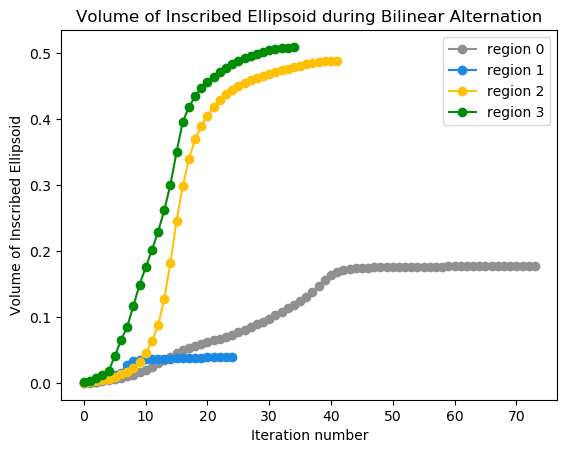

In [57]:
import matplotlib.pyplot as plt
plt.clf()
for i, result in enumerate(bilinear_alternation_results_by_seed_point.values()):
    color = (colors_dict[i].r(), colors_dict[i].g(), colors_dict[i].b())
    data = [(c.num_iter, c.certified_polytope.MaximumVolumeInscribedEllipsoid().Volume()) 
        for (_, c, _) in result]
    x, y = map(list, zip(*data))
    plt.plot(x, y, color = color, marker = 'o', label = f"region {i}")
plt.xlabel("Iteration number")
plt.ylabel("Volume of Inscribed Ellipsoid")
plt.title("Volume of Inscribed Ellipsoid during Bilinear Alternation")
plt.legend()
plt.savefig("pinball_vol.svg")
plt.show()

In [49]:
list(bilinear_alternation_results_by_seed_point.values())[0]

[(<pydrake.geometry.optimization.HPolyhedron at 0x7fdd0b25f6b0>,
  Rgba(r=0.565, g=0.565, b=0.565, a=0.2)),
 (<pydrake.geometry.optimization.HPolyhedron at 0x7fdd0b1a02b0>,
  Rgba(r=0.565, g=0.565, b=0.565, a=0.2)),
 (<pydrake.geometry.optimization.HPolyhedron at 0x7fdd0b199b70>,
  Rgba(r=0.565, g=0.565, b=0.565, a=0.2)),
 (<pydrake.geometry.optimization.HPolyhedron at 0x7fdd0b1a09f0>,
  Rgba(r=0.565, g=0.565, b=0.565, a=0.2)),
 (<pydrake.geometry.optimization.HPolyhedron at 0x7fdd0b1a0370>,
  Rgba(r=0.565, g=0.565, b=0.565, a=0.2)),
 (<pydrake.geometry.optimization.HPolyhedron at 0x7fdd0b1a07f0>,
  Rgba(r=0.565, g=0.565, b=0.565, a=0.2)),
 (<pydrake.geometry.optimization.HPolyhedron at 0x7fdd0b1a0ab0>,
  Rgba(r=0.565, g=0.565, b=0.565, a=0.2)),
 (<pydrake.geometry.optimization.HPolyhedron at 0x7fdd0b1a07b0>,
  Rgba(r=0.565, g=0.565, b=0.565, a=0.2)),
 (<pydrake.geometry.optimization.HPolyhedron at 0x7fdd0b1a0af0>,
  Rgba(r=0.565, g=0.565, b=0.565, a=0.2)),
 (<pydrake.geometry.optimiza

# Growing regions with binary search

### While the bilinear alternation scheme has the flexibility to search for fairly flexible polytopes, it can be relatively slow. We can search for larger regions faster by uniformly growing our polytopes using binary search

In [11]:
# We grow certified regions around each seedpoint using binary search.
binary_search_results_by_seed_point = dict.fromkeys([tuple(s) for s in seed_points])
for i, (s, (initial_region, color)) in enumerate(zip(seed_points, initial_regions)):
    print(f"starting seedpoint {i+1}/{len(initial_regions)}")
    time.sleep(0.2)
    cert = cspace_free_polytope.BinarySearch(set(),initial_region.A(),
                                               initial_region.b(),s,binary_search_options)
    binary_search_results_by_seed_point[tuple(s)] = [(polytope_with_joint_limits(cert.C, cert.d), cert, color)]
                                                     


starting seedpoint 1/4


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=25.5 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=13.25 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=7.125 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=10.1875 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=11.71875 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=10.953125 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=11.3359375 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=11.14453125 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=11.048828125 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=11.0009765625 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=11.02490234375 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=11.012939453125 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=11.0069580078125 is infeas

starting seedpoint 2/4


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=25.5 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=13.25 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=7.125 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=4.0625 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=2.53125 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=1.765625 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=2.1484375 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=1.95703125 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=1.861328125 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=1.8134765625 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=1.83740234375 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=1.825439453125 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=1.8194580078125 is infeasible
I

starting seedpoint 3/4


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=25.5 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=13.25 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=19.375 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=16.3125 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=17.84375 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=17.078125 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=16.6953125 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=16.50390625 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=16.408203125 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=16.3603515625 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=16.33642578125 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=16.324462890625 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=16.3184814453125 is i

starting seedpoint 4/4


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=25.5 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=13.25 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=19.375 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=22.4375 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=23.96875 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=24.734375 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=25.1171875 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=24.92578125 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=24.830078125 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=24.7822265625 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=24.75830078125 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=24.770263671875 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=24.7762451171875 is infeasible


In [12]:
# visualize the regions and corresponding certificates
for i, result in enumerate(binary_search_results_by_seed_point.values()):
    group_name = f"/bin_search_seed_point_{i}"
    visualizer.add_group_of_regions_and_certs_to_visualization(result, group_name, 
                                                               wireframe = False, opacity = 0.2)

## Combining Binary Search and Bilinear Alternation
### Of course, we can get the best of both worlds by combining the two methods

In [13]:
# we use this to back off a bit from the binary search results for numerical reasons
def scale_polytope_about_point(hpoly, s, scale):
    if not hpoly.PointInSet(s):
        raise ValueError(f"The point s must be in the HPolyhedron")
    b_scaled = scale * hpoly.b() + (1 - scale) * hpoly.A() @ s
    return HPolyhedron(hpoly.A(), b_scaled)
    

In [14]:
# Now we grow certified regions around each seedpoint using bilinear alternation 
# starting from the binary certified regions.

binary_and_bilinear_certified_regions = {k: [(r, cert, color)] for k,v in binary_search_results_by_seed_point.items() 
                                   for (r, cert, color) in v}

for i, (s, region_list) in enumerate(binary_and_bilinear_certified_regions.items()):
    bin_search_region, cert0, color = region_list[0]
    print(f"starting seedpoint {i+1}/{len(initial_regions)}")
    time.sleep(0.2)
    cur_s = np.array(s)
    bilinear_alternation_options.find_polytope_options.s_inner_pts = cur_s
    
    # We back off a little bit from the binary search solution so that we don't encounter numerical issues.
    initial_region = scale_polytope_about_point(bin_search_region, cur_s, 0.98)
    certificates = cspace_free_polytope.SearchWithBilinearAlternation(set(),
                                                                      initial_region.A(),
                                                                      initial_region.b(), 
                                                                      bilinear_alternation_options)
    
    binary_and_bilinear_certified_regions[s] += [(polytope_with_joint_limits(result.C, result.d), result, color) for result in certificates]

starting seedpoint 1/4


INFO:drake:det(Q) at the beginning is 0.00569890128581006
INFO:drake:Iteration 0: det(Q)=0.00754256198451188
INFO:drake:Iteration 1: det(Q)=0.009965538370257942
INFO:drake:Iteration 2: det(Q)=0.012493189547045157
INFO:drake:Iteration 3: det(Q)=0.01546305843358848
INFO:drake:Iteration 4: det(Q)=0.019070818018186556
INFO:drake:Iteration 5: det(Q)=0.023739846202219948
INFO:drake:Iteration 6: det(Q)=0.028385992625492275
INFO:drake:Iteration 7: det(Q)=0.0328233704698433
INFO:drake:Iteration 8: det(Q)=0.03680946757326833
INFO:drake:Iteration 9: det(Q)=0.039600703317339676
INFO:drake:Iteration 10: det(Q)=0.04192563151268203
INFO:drake:Iteration 11: det(Q)=0.0439217889952243
INFO:drake:Iteration 12: det(Q)=0.0455924441255354
INFO:drake:Iteration 13: det(Q)=0.04700079719296696
INFO:drake:Iteration 14: det(Q)=0.04817445271796419
INFO:drake:Iteration 15: det(Q)=0.049141941198555736
INFO:drake:Iteration 16: det(Q)=0.04992692549124149
INFO:drake:Iteration 17: det(Q)=0.05055552733295339
INFO:drake:I

starting seedpoint 2/4


INFO:drake:det(Q) at the beginning is 0.00015516369726714313
INFO:drake:Iteration 0: det(Q)=0.00038694282163595235
INFO:drake:Iteration 1: det(Q)=0.0007190150467633258
INFO:drake:Iteration 2: det(Q)=0.0013787497655209366
INFO:drake:Iteration 3: det(Q)=0.003042999074126276
INFO:drake:Iteration 4: det(Q)=0.009267637442854377
INFO:drake:Iteration 5: det(Q)=0.012129201033342595
INFO:drake:Iteration 6: det(Q)=0.014587245079641672
INFO:drake:Iteration 7: det(Q)=0.0181730003489196
INFO:drake:Iteration 8: det(Q)=0.020890027893586332
INFO:drake:Iteration 9: det(Q)=0.02253873331839624
INFO:drake:Iteration 10: det(Q)=0.023365308429131797
INFO:drake:Iteration 11: det(Q)=0.023769097308052392
INFO:drake:Iteration 12: det(Q)=0.024064947989822068
INFO:drake:Iteration 13: det(Q)=0.024200296301386714
INFO:drake:Iteration 14: det(Q)=0.024259355118227598
INFO:drake:Iteration 15: det(Q)=0.02427083220987526
INFO:drake:Iteration 16: det(Q)=0.02425897803585759


starting seedpoint 3/4


INFO:drake:det(Q) at the beginning is 0.012528319755106522
INFO:drake:Iteration 0: det(Q)=0.016857169144092552
INFO:drake:Iteration 1: det(Q)=0.023401862493767328
INFO:drake:Iteration 2: det(Q)=0.031147194459443455
INFO:drake:Iteration 3: det(Q)=0.03945798756168899
INFO:drake:Iteration 4: det(Q)=0.0506246054561291
INFO:drake:Iteration 5: det(Q)=0.06416193493323818
INFO:drake:Iteration 6: det(Q)=0.08422486717974194
INFO:drake:Iteration 7: det(Q)=0.10479760829573571
INFO:drake:Iteration 8: det(Q)=0.12383926675078712
INFO:drake:Iteration 9: det(Q)=0.13141776226394886
INFO:drake:Iteration 10: det(Q)=0.13764628273184054
INFO:drake:Iteration 11: det(Q)=0.1424717412410019
INFO:drake:Iteration 12: det(Q)=0.14615469160895928
INFO:drake:Iteration 13: det(Q)=0.1489776969205038
INFO:drake:Iteration 14: det(Q)=0.15116338422343809
INFO:drake:Iteration 15: det(Q)=0.15284390824238997
INFO:drake:Iteration 16: det(Q)=0.15409118781971035
INFO:drake:Iteration 17: det(Q)=0.15495961300154695
INFO:drake:Iter

starting seedpoint 4/4


INFO:drake:det(Q) at the beginning is 0.028878858410501265
INFO:drake:Iteration 0: det(Q)=0.03750961347247706
INFO:drake:Iteration 1: det(Q)=0.05214383533403912
INFO:drake:Iteration 2: det(Q)=0.06267935341553389
INFO:drake:Iteration 3: det(Q)=0.07455068012303114
INFO:drake:Iteration 4: det(Q)=0.08757563305060503
INFO:drake:Iteration 5: det(Q)=0.10505287302774778
INFO:drake:Iteration 6: det(Q)=0.11928414761366087
INFO:drake:Iteration 7: det(Q)=0.127533590126375
INFO:drake:Iteration 8: det(Q)=0.13334776259182507
INFO:drake:Iteration 9: det(Q)=0.1376009169783101
INFO:drake:Iteration 10: det(Q)=0.14082701934787661
INFO:drake:Iteration 11: det(Q)=0.14346636661185244
INFO:drake:Iteration 12: det(Q)=0.14583155160670536
INFO:drake:Iteration 13: det(Q)=0.1479625534641944
INFO:drake:Iteration 14: det(Q)=0.14983409708303794
INFO:drake:Iteration 15: det(Q)=0.15148812070617299
INFO:drake:Iteration 16: det(Q)=0.1529569923707007
INFO:drake:Iteration 17: det(Q)=0.1542303677743081
INFO:drake:Iteration 

In [15]:
# visualize the regions and corresponding certificates
for i, result in enumerate(binary_and_bilinear_certified_regions.values()):
    group_name = f"/bin_then_bil_search_seed_point_{i}"
    visualizer.add_group_of_regions_and_certs_to_visualization(result, group_name, 
                                                               wireframe = False, opacity = 0.2)

## Seeding and Certifying with a Stronger Heuristic
We have also implemented another, strong heuristic for proposing good initial regions based on non-linear optimization. See Appendix TODO of our paper TODO for details

In [16]:
iris_regions = []
iris_ellipses = []

iris_options = IrisOptions()
iris_options.require_sample_point_is_contained = True
iris_options.configuration_space_margin = 1e-3
iris_options.relative_termination_threshold = 0.001

context_for_iris = visualizer.task_space_diagram_context
for i, s in enumerate(seed_points):
    q = Ratfk.ComputeQValue(s, q_star)
    plant.SetPositions(plant.GetMyMutableContextFromRoot(context_for_iris), q)
    r = IrisInRationalConfigurationSpace(plant, 
                                         plant.GetMyContextFromRoot(context_for_iris),
                                         q_star, iris_options)
    iris_regions.append((r, colors_dict[i]))
    iris_ellipses.append(r.MaximumVolumeInscribedEllipsoid())
    



In [17]:
visualizer.add_group_of_regions_to_visualization(iris_regions, "/uncertified-iris", 
                                                            wireframe = False, opacity = 0.2)

### These regions tend to be very large, but typically are not completely collision free. We can use the binary search method to find a uniform shrinking of these regions to prove their safety and then again improve them with bilinear alternations.

In [18]:
binary_search_options_for_iris = CspaceFreePolytope.BinarySearchOptions()
binary_search_options_for_iris.scale_max = 1.1 # it is highly unlikely that the regions can grow, but we can try
binary_search_options_for_iris.find_lagrangian_options = find_separation_certificate_given_polytope_options
binary_search_options_for_iris.max_iter = 50

In [19]:
binary_search_region_certificates_for_iris = dict.fromkeys([tuple(s) for s in seed_points])
for i, (s, (initial_region, color)) in enumerate(zip(seed_points, iris_regions)):
    print(f"starting seedpoint {i+1}/{len(iris_regions)}")
    time.sleep(0.2)    
    cert = cspace_free_polytope.BinarySearch(set(),
                                                    initial_region.A(),
                                                    initial_region.b(), 
                                                    initial_region.MaximumVolumeInscribedEllipsoid().center(), 
                                                    binary_search_options_for_iris)
    binary_search_region_certificates_for_iris[tuple(s)] = [(polytope_with_joint_limits(cert.C, cert.d),
                                                             cert, color)]

starting seedpoint 1/4


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.555 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.8275000000000001 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.9637500000000001 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=1.031875 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.9978125000000001 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=1.01484375 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=1.006328125 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=1.0020703125000001 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.99994140625 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=1.0010058593750002 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=1.0004736328125001 is feasible


starting seedpoint 2/4


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.555 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.8275000000000001 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.9637500000000001 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=1.031875 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.9978125000000001 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=1.01484375 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=1.006328125 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=1.0020703125000001 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.99994140625 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=1.0010058593750002 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=1.0015380859375003 is infeasible


starting seedpoint 3/4


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.555 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.8275000000000001 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.9637500000000001 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=1.031875 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.9978125000000001 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=1.01484375 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=1.006328125 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=1.0020703125000001 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=1.0041992187500002 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=1.003134765625 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=1.0026025390625 is infeasible


starting seedpoint 4/4


INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.555 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.8275000000000001 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.9637500000000001 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=1.031875 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.9978125000000001 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=1.01484375 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=1.006328125 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=1.0020703125000001 is infeasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=0.99994140625 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=1.0010058593750002 is feasible
INFO:drake:CspaceFreePolytope::BinarySearch(): scale=1.0015380859375003 is infeasible


In [31]:
for i, result in enumerate(binary_search_region_certificates_for_iris.values()):
    group_name = f"/certified-iris-bin_seed_point_{i}"
    visualizer.add_group_of_regions_and_certs_to_visualization(result, group_name, 
                                                            wireframe = False, opacity = 0.2)

In [21]:
# Finally we grow the regions again using bilinear alternations.

# Manual copying of binary_search_region_certificates_for_iris to avoid reference semantics
bilinear_certified_regions_iris = {k: [(r, cert, color)] for k,v in binary_search_region_certificates_for_iris.items() 
                                   for (r, cert, color) in v}

for i, (s, region_list) in enumerate(bilinear_certified_regions_iris.items()):
    bin_search_region, cert0, color = region_list[0]
    print(f"starting seedpoint {i+1}/{len(initial_regions)}")
    time.sleep(0.2)
    cur_s = np.array(s)
    bilinear_alternation_options.find_polytope_options.s_inner_pts = cur_s
    
    # We back off a little bit from the binary search solution so that we don't encounter numerical issues.
    initial_region = scale_polytope_about_point(bin_search_region, cur_s, 0.90)
    certificates = cspace_free_polytope.SearchWithBilinearAlternation(set(),
                                                                      initial_region.A(),
                                                                      initial_region.b(), 
                                                                      bilinear_alternation_options)
    bilinear_certified_regions_iris[s] += [(polytope_with_joint_limits(result.C, result.d), result, color) for result in certificates]

starting seedpoint 1/4


INFO:drake:det(Q) at the beginning is 0.04485477206328302
INFO:drake:Iteration 0: det(Q)=0.0468526495872986
INFO:drake:Iteration 1: det(Q)=0.04845533444437721
INFO:drake:Iteration 2: det(Q)=0.049733199025223745
INFO:drake:Iteration 3: det(Q)=0.050731345971946534
INFO:drake:Iteration 4: det(Q)=0.051578095523934574
INFO:drake:Iteration 5: det(Q)=0.052250183901524
INFO:drake:Iteration 6: det(Q)=0.05305475984843805
INFO:drake:Iteration 7: det(Q)=0.053643727121673646
INFO:drake:Iteration 8: det(Q)=0.05408900787513691
INFO:drake:Iteration 9: det(Q)=0.05443042268388365
INFO:drake:Iteration 10: det(Q)=0.05469635731977336
INFO:drake:Iteration 11: det(Q)=0.05490655428139217
INFO:drake:Iteration 12: det(Q)=0.05507469212032591
INFO:drake:Iteration 13: det(Q)=0.05521049290002021
INFO:drake:Iteration 14: det(Q)=0.055318833265388855
INFO:drake:Iteration 15: det(Q)=0.055404819506447586
INFO:drake:Iteration 16: det(Q)=0.055472791003409294
INFO:drake:Iteration 17: det(Q)=0.05552704271512549
INFO:drake:I

starting seedpoint 2/4


INFO:drake:det(Q) at the beginning is 0.01894783957781191
INFO:drake:Iteration 0: det(Q)=0.021285520592976278
INFO:drake:Iteration 1: det(Q)=0.022371398734085873
INFO:drake:Iteration 2: det(Q)=0.023036615659689286
INFO:drake:Iteration 3: det(Q)=0.023453853265268818
INFO:drake:Iteration 4: det(Q)=0.023731386223466742
INFO:drake:Iteration 5: det(Q)=0.023923094779487404
INFO:drake:Iteration 6: det(Q)=0.024058104832479558
INFO:drake:Iteration 7: det(Q)=0.024150691126551584
INFO:drake:Iteration 8: det(Q)=0.02421273837842561
INFO:drake:Iteration 9: det(Q)=0.024259308036682015
INFO:drake:Iteration 10: det(Q)=0.024285870613633454
INFO:drake:Iteration 11: det(Q)=0.024306279552964966
INFO:drake:Iteration 12: det(Q)=0.024316377376873487
INFO:drake:Iteration 13: det(Q)=0.024313842535549197


starting seedpoint 3/4


INFO:drake:det(Q) at the beginning is 0.13312985139860692
INFO:drake:Iteration 0: det(Q)=0.1550569667281601
INFO:drake:Iteration 1: det(Q)=0.15690507686590005
INFO:drake:Iteration 2: det(Q)=0.15807635249841132
INFO:drake:Iteration 3: det(Q)=0.158949498101628
INFO:drake:Iteration 4: det(Q)=0.15953341651188202
INFO:drake:Iteration 5: det(Q)=0.16005308604310461
INFO:drake:Iteration 6: det(Q)=0.16052412418989523
INFO:drake:Iteration 7: det(Q)=0.1609052139415095
INFO:drake:Iteration 8: det(Q)=0.16119150283560812
INFO:drake:Iteration 9: det(Q)=0.16140424035262246
INFO:drake:Iteration 10: det(Q)=0.1616234967917872
INFO:drake:Iteration 11: det(Q)=0.1617791225941173
INFO:drake:Iteration 12: det(Q)=0.1618950310657837
INFO:drake:Iteration 13: det(Q)=0.1619865005483999
INFO:drake:Iteration 14: det(Q)=0.16206031189008754
INFO:drake:Iteration 15: det(Q)=0.1621215594980243
INFO:drake:Iteration 16: det(Q)=0.16217248578263463
INFO:drake:Iteration 17: det(Q)=0.1622139557100185
ERROR:drake:Cannot find th

starting seedpoint 4/4


INFO:drake:det(Q) at the beginning is 0.12885670304239377
INFO:drake:Iteration 0: det(Q)=0.14372658105064762
INFO:drake:Iteration 1: det(Q)=0.1476455122058243
INFO:drake:Iteration 2: det(Q)=0.15022078286347815
INFO:drake:Iteration 3: det(Q)=0.15209591914042586
INFO:drake:Iteration 4: det(Q)=0.1535829714892516
INFO:drake:Iteration 5: det(Q)=0.15480641933944922
INFO:drake:Iteration 6: det(Q)=0.15582195273983215
INFO:drake:Iteration 7: det(Q)=0.15665483945910486
INFO:drake:Iteration 8: det(Q)=0.15733424670964957
INFO:drake:Iteration 9: det(Q)=0.15787150132638123
INFO:drake:Iteration 10: det(Q)=0.1583207435215288
INFO:drake:Iteration 11: det(Q)=0.15868629123963762
INFO:drake:Iteration 12: det(Q)=0.15899100819898287
INFO:drake:Iteration 13: det(Q)=0.15924535237002319
INFO:drake:Iteration 14: det(Q)=0.1594577261487279
INFO:drake:Iteration 15: det(Q)=0.15962991707646818
INFO:drake:Iteration 16: det(Q)=0.15977024242918705
INFO:drake:Iteration 17: det(Q)=0.15988825583593733
INFO:drake:Iteration

In [22]:
for i, result in enumerate(bilinear_certified_regions_iris.values()):
    visualizer.add_group_of_regions_and_certs_to_visualization(result, "/certified-iris-bil", 
                                                            wireframe = False, opacity = 0.2)

# Now it is time to play with the visualization! If you open the task space visualizer, we can highlight specific geometries and their separating planes in different regions.
## Notice that when regions overlap, we get multiple planes certifying non-collision

In [23]:
# This plane certifies that the two tips of the flippers don't intersect
visualizer.add_plane_indices_of_interest(118)

# re-display the sliders for convenience
for slider in sliders:
    display(slider)

FloatSlider(value=0.0, description='q0', max=1.7, min=-1.7)

FloatSlider(value=0.0, description='q1', max=1.7, min=-1.7)

In [24]:
# Uncomment this cell for an interface for choosing good planes of interest
# plane_indices = np.arange(0, len(cspace_free_polytope.separating_planes()))
# last_plane_index = 0
# cur_plane_index = 0
# plane_indices_to_geometries = {v: k for k,v in cspace_free_polytope.map_geometries_to_separating_planes().items()}

# while True:
#     visualizer.meshcat_task_space.Delete(f"/plane_{last_plane_index}")
#     geom1, geom2 = plane_indices_to_geometries[cur_plane_index]
#     color = Rgba(0,0,1,1)
    
#     prefix = f"/plane_{cur_plane_index}"
#     visualizer.highlight_geometry_id(geom1, color, prefix+f"/{geom1}")
#     visualizer.highlight_geometry_id(geom2, color, prefix+f"/{geom2}")
#     print(f"current plane index = {cur_plane_index}")
    
#     last_plane_index = cur_plane_index
#     valid_key_pressed = False
#     while not valid_key_pressed:
#         key_press = input("Enter d to increase plane_count, a to decrease, and e to exit...")
#         if key_press in ["a", "d", "e"]:
#             valid_key_pressed = True
#     if key_press == "a":
#         cur_plane_index = max(cur_plane_index - 1, min(plane_indices))
#     elif key_press == "d":
#         cur_plane_index = min(cur_plane_index + 1, max(plane_indices))
#     elif key_press == "e":
#         break
#     print()

In [25]:
# Uncomment this cell for seeing all the planes associated to a particular geometry id
# interesting_geometry = 92
# plane_indices = np.arange(0, len(cspace_free_polytope.separating_planes()))
# plane_indices_to_geometries = {v: k for k,v in cspace_free_polytope.map_geometries_to_separating_planes().items()}

# associated_plane_indices = []
# for plane_index, (geom1, geom2) in plane_indices_to_geometries.items():
#     if interesting_geometry in (geom1.get_value(), geom2. get_value()):
#         associated_plane_indices.append(plane_index)

        
# last_associated_index_index = 0
# cur_associated_index_index = 0

# visualizer.clear_plane_indices_of_interest()
# while True:
#     last_plane_index = associated_plane_indices[last_associated_index_index]
#     cur_plane_index = associated_plane_indices[cur_associated_index_index]
    
#     print(f"current plane index = {cur_plane_index}")
    
#     visualizer.remove_plane_indices_of_interest(last_plane_index)
#     visualizer.add_plane_indices_of_interest(cur_plane_index)
    
#     cur_q = visualizer.plant.GetPositions(visualizer.plant_context)
#     visualizer.show_res_q(cur_q)
    
#     last_associated_index_index = cur_associated_index_index
#     valid_key_pressed = False
#     while not valid_key_pressed:
#         key_press = input("Enter d to increase plane_count, a to decrease, and e to exit...")
#         if key_press in ["a", "d", "e"]:
#             valid_key_pressed = True
#     if key_press == "a":
#         cur_associated_index_index = max(cur_associated_index_index - 1, min(associated_plane_indices))
#     elif key_press == "d":
#         cur_associated_index_index = min(cur_associated_index_index + 1, max(associated_plane_indices))
#     elif key_press == "e":
#         break
#     print()

In [29]:
visualizer.meshcat_task_space.Delete("/certified-iris-bil")
for i in range(seed_points.shape[0]):
    visualizer.meshcat_task_space.Delete(f"/bil_alt_seed_point_{i}")
    visualizer.meshcat_task_space.Delete(f"/bin_search_seed_point_{i}")
    visualizer.meshcat_task_space.Delete(f"/bin_then_bil_search_seed_point_{i}")

In [38]:
# This plane certifies that the two tips of the flippers don't intersect
visualizer.add_plane_indices_of_interest(118)

# re-display the sliders for convenience
for slider in sliders:
    display(slider)

FloatSlider(value=0.7, description='q0', max=1.7, min=-1.7)

FloatSlider(value=-1.2, description='q1', max=1.7, min=-1.7)

In [39]:
cur_q = visualizer.plant.GetPositions(visualizer.plant_context)
cur_s = Ratfk.ComputeSValue(cur_q, q_star)
visualizer.plot_cspace_points(cur_s, name='/s', color=Rgba(0.24, 1, 0, 1), radius=0.03)